# Data Cleaning & Exploration


### 1. The Machine Learning Process

### 2. Introduction to Matplotlib and Seaborn

### 3. Correcting Categorical Features

In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPArK_DRIVeR_PYTHON'] = sys.executable

In [10]:
# Import appropriate modules for starting spark session, using pandas on spark, and accessing math functions
import pandas as pd
from pyspark.sql import SparkSession
import numpy as np
import pyspark.pandas as ps
spark = SparkSession.builder.master('local[*]').appName('my-app').getOrCreate()

# Read in S&P 500 data set using pandas
financials = pd.read_csv("financials.csv") 
findata = spark.createDataFrame(financials) #convert to spark data frame

# Create training and test set with 80%/20% split, returning #obs in each set
# We will use THESE sets during modeling
train, test = findata.randomSplit([0.8, 0.2], seed = 3)
print(train.count(), test.count())

398 107


In [8]:
# Convert training set above to pandas-on-spark data set for easier EDA
fintrain = train.to_pandas_on_spark()

# Return unique values of Sector variable
fintrain.Sector.unique()

0                    Health Care
1                         Energy
2         Information Technology
3     Telecommunication Services
4                    Real Estate
5                      Materials
6         Consumer Discretionary
7                      Utilities
8               Consumer Staples
9                    Industrials
10                    Financials
Name: Sector, dtype: object

In [9]:
# Describe numeric variables in data set
fintrain.describe()

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
count,398.000000,396.000000,398.000000,398.000000,398.000000,398.000000,3.980000e+02,3.980000e+02,398.000000,391.000000
mean,102.410754,24.102955,1.842285,3.611382,120.914205,82.683013,4.665611e+10,3.516603e+09,3.906511,11.616547
std,126.451627,32.160682,1.544059,5.604250,147.115407,104.402618,8.279151e+10,6.894029e+09,3.443362,69.944221
min,2.820000,-251.530000,0.000000,-28.010000,6.590000,2.800000,2.626102e+09,-5.067000e+09,0.173970,0.510000
25%,46.250000,15.390000,0.755124,1.490000,56.580000,37.820000,1.246666e+10,7.367980e+08,1.614736,2.080000
50%,74.510000,19.710000,1.667825,2.930000,88.000000,63.410000,2.103272e+10,1.561000e+09,2.839671,3.490000
75%,116.540000,25.900000,2.669978,5.140000,139.240000,97.880000,4.402709e+10,3.459800e+09,4.703259,6.010000
max,1806.060000,305.560000,12.661196,44.090000,2067.990000,1589.000000,8.095080e+11,7.938600e+10,20.094294,1318.700000


In [37]:
# View mean Price, Price/Earnings, Earnings/Share, and EBITDA for each sector
fintrain.groupby(["Sector"])[["Price","Price/Earnings", "Earnings/Share", "EBITDA"]].agg("mean")

,Price,Price/Earnings,Earnings/Share,EBITDA
Sector,,,,
Health Care,135.145532,NaN,3.501277,3.393920e+09
Energy,53.751600,42.552000,-1.996000,4.768612e+09
Information Technology,109.265200,31.963000,2.768200,6.198590e+09
Telecommunication Services,25.885000,10.245000,2.960000,2.761500e+10
Real Estate,92.233704,16.758889,2.624074,1.389846e+09
Materials,109.136667,24.624762,5.023810,2.183784e+09
Consumer Discretionary,118.355147,NaN,5.146765,3.578287e+09
Utilities,58.751429,16.409524,1.968095,3.659682e+09
Consumer Staples,83.117931,22.173793,3.793448,5.064501e+09


In [47]:
# Find quantiles of Price
fintrain.Price.quantile([0.01, 0.25, 0.5, 0.75, 0.99])

0.01     11.95
0.25     46.25
0.50     74.51
0.75    116.54
0.99    601.00
Name: Price, dtype: float64

In [59]:
# Create categorical version of Price variable with levels "Low" "Medium" and "High" based on quantiles above

from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import *

def categorizer(price):
    if price < 46.25:
        return "Low"
    elif price < 116.54:
        return "Mid"
    else:
        return "High"
    
pricecat_udf = udf(categorizer, StringType())
fintrain = train.withColumn("Price_cat", pricecat_udf("Price")).to_pandas_on_spark()
fintrain.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,Price_cat
0,A,Agilent Technologies Inc,Health Care,65.05,27.45,0.875698,2.10,75.00,49.23,2.198461e+10,1.094000e+09,6.493563,4.56,http://www.sec.gov/cgi-bin/browse-edgar?action...,Mid
1,AAL,American Airlines Group,Industrials,48.60,9.92,0.778210,3.91,59.08,39.21,2.459485e+10,5.761000e+09,0.580226,6.03,http://www.sec.gov/cgi-bin/browse-edgar?action...,Mid
2,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.20,180.10,131.12,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...,High
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.05,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,Mid
4,ABC,AmerisourceBergen Corp,Health Care,91.55,15.54,1.613246,1.64,106.27,71.90,2.058770e+10,9.918840e+08,0.173970,9.73,http://www.sec.gov/cgi-bin/browse-edgar?action...,Mid


In [66]:
# create pivot table returning mean EBITDA for each Sector/Price Level

fintrain.pivot_table(index = ["Sector"], columns = 'Price_cat', values = "EBITDA", aggfunc = "mean")

Price_cat,High,Low,Mid
Sector,,,
Health Care,2.691627e+09,5.465789e+09,3.457105e+09
Energy,2.151190e+09,1.280093e+09,9.129354e+09
Information Technology,9.592985e+09,6.086267e+09,4.043457e+09
Telecommunication Services,NaN,2.761500e+10,NaN
Real Estate,2.397553e+09,1.137779e+09,1.075044e+09
Materials,2.214919e+09,1.240200e+09,2.539423e+09
Consumer Discretionary,4.227208e+09,4.363204e+09,2.656591e+09
Utilities,9.018000e+09,2.696450e+09,3.855309e+09
Consumer Staples,2.567267e+09,2.460272e+09,7.140314e+09


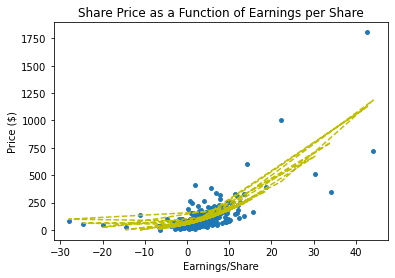

In [98]:
# Use matplotlib to plot earnings per share against price

import seaborn as sns
import matplotlib.pyplot as plt

fintrain.Sector = fintrain.Sector.astype('category')

plt.scatter(x = fintrain["Earnings/Share"].to_numpy(), y = fintrain["Price"].to_numpy(),
           s = 15)
plt.xlabel("Earnings/Share")
plt.ylabel("Price ($)")
plt.title("Share Price as a Function of Earnings per Share")

x = fintrain["Earnings/Share"].to_numpy()
y = fintrain["Price"].to_numpy()

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

plt.plot(x, p(x), "y--")

### 4. Outliers & Unwanted Observations

In [ ]:
# Display the dimensions of the stock_data DataFrame



In [ ]:
# Display histograms for all continuous features



In [ ]:
# Display the box distribution of 'Beta' by 'Sector'



In [ ]:
# Display the box distribution of 'Return' by 'Sector'

